# Scientific Python
## Central European University // Fall 2021

## Final Project
Instructor: Marton Posfai

Student: Alessandra Oshiro


## 1. Introduction

In this project, my aim is twofold. First, I will explore the "Mass Mobilization Data" dataset in look for interesting trends and patterns across regions. Second, I will try to build a machine learning model using logistic regression to predict forceful state response against protesters. Initially, my hypothesis is that the duration of the mobilization and the demands of the protesters play a relevant role in determining the state response. Nevertheless, the data exploration might indicate additional variables to be considered in the machine learning section. 

"Mass Mobilization Data" was elaborated by David Clark and Reagan Patrick. Made publicly available in 2016, it contains data of mass mobilizations (i.e., protests with at least 50 participants) ocurred between 1990 and 2014, in 162 different countries. For more information about the dataset and the variables, the codebook and the dataset can be accessed through the following link: https://doi.org/10.7910/DVN/HTTWYL/TJJZNG. 

## 2. Loading And Cleaning The Dataset


In this section, I will prepare the data for the exploration and machine learning sections that come later. This process includes dealing with `NaN`s, deciding which variables are useful for the project, renaming the variables so that they are more informative, among other things. Each part of the data cleaning process is explained in more detail before the corresponding code. 


First, it is necessary to import the modules to be used throughout the project.


In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

Then, I load the data and use the "head" function to have a better idea of what the dataset looks like. The use of the `info` function serves the same purpose, as it provides useful information about the `NaN` values and object types in each variable. 

In [2]:
social_movements_df = pd.read_csv("social_movements.csv")
social_movements_df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,201990003,Canada,20,1990,North America,1,3,1.0,7.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,201990004,Canada,20,1990,North America,1,4,12.0,7.0,1990.0,...,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,201990005,Canada,20,1990,North America,1,5,14.0,8.0,1990.0,...,NaN,crowd dispersal,arrests,accomodation,NaN,NaN,NaN,NaN,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...


In [3]:
social_movements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     17145 non-null  int64  
 1   country                17145 non-null  object 
 2   ccode                  17145 non-null  int64  
 3   year                   17145 non-null  int64  
 4   region                 17145 non-null  object 
 5   protest                17145 non-null  int64  
 6   protestnumber          17145 non-null  int64  
 7   startday               15239 non-null  float64
 8   startmonth             15239 non-null  float64
 9   startyear              15239 non-null  float64
 10  endday                 15239 non-null  float64
 11  endmonth               15239 non-null  float64
 12  endyear                15239 non-null  float64
 13  protesterviolence      15758 non-null  float64
 14  location               15218 non-null  object 
 15  pa

With a better picture of the dataset, I start the data cleaning process. First, I drop the columns that are not necessary for the analysis. These variables were either redundant, irrelevant, or were coded in a way that made it difficult to process and recode for the machine learning model.

In [4]:
social_movements_df.drop(["id", "ccode", "protesteridentity", "participants_category", "location", "sources", "notes", "protestnumber", "participants"], 
                            axis = 1, inplace = True)

Additionaly, I eliminate the observations after 2014. The manual said it has data up to that year, however, there are some observations that ocurred in later years. I dediced not to include these because there are too few of them. 

In [5]:
social_movements_df = social_movements_df[social_movements_df["year"] < 2014]

Another thing to consider during the cleaning is the amount of `NaN` values. As the initial summary indicates, there are several variables that have a noticeable amount of missing values. To have a better picture of this, I calculate the proportion of `NaN` values per column.

In [6]:
# Function that will output the proportion of NaN values for each column
def print_na_proportion(df):
    print(df.isna().sum()/len(df))

In [7]:
print_na_proportion(social_movements_df)

country              0.000000
year                 0.000000
region               0.000000
protest              0.000000
startday             0.119492
startmonth           0.119492
startyear            0.119492
endday               0.119492
endmonth             0.119492
endyear              0.119492
protesterviolence    0.076986
protesterdemand1     0.119574
protesterdemand2     0.865192
protesterdemand3     0.979197
protesterdemand4     0.998608
stateresponse1       0.122031
stateresponse2       0.829648
stateresponse3       0.947174
stateresponse4       0.985831
stateresponse5       0.996888
stateresponse6       0.999017
stateresponse7       0.999427
dtype: float64


As mentioned in the introduction, my interest in this project is to explore trends in mass mobilizations and try to predict how states respond to them. The calculation for the `NaN` values proportion shows that some of the variables for state response and protester demands are mostly filled with missing values. However, fortunately, this is only the cases in which the mobilization had more than one demand or the state had more than one response. Because of this, I decided to restrict the sample only to the cases in which the mobilization had one demand and the state had one response to it. The following section deals with the cleaning of `NaN` values in the variables which are important for the attempt of predicting the state response (i.e., `stateresponse`, `protesterdemand`, and `protesterviolence`). 

In [8]:
social_movements_df.dropna(subset = ["stateresponse1", "protesterdemand1", "protesterviolence"], inplace = True)

Dropping the `NaN` values for the important variables mentioned above led to a removal of missing values in most of the other variables. However, the proportion of `NaN` values in variables for additional protester demands and state responses are still high. As clarified before, I decided to restrict the sample only to the cases which show one demand and one response. I opted for this instead of straightforwardly dropping the additional variables because the dataset does not specify if the demands and responses are ordered according to importance or temporal sequence. Therefore, keeping the first demand and the first response of every case regardless of there being additional demands or responses would give us unaccurate information.

The following code filters the dataset so that it includes only the cases in which there was only one demand and once response. It then drops the columns with additional demands or response data. Finally, it drops any additional `NaN` value. 

In [9]:
social_movements_df = social_movements_df[social_movements_df["stateresponse2"].isna()]
social_movements_df = social_movements_df[social_movements_df["protesterdemand2"].isna()]

In [10]:
social_movements_df.drop(
    ["protesterdemand2", "protesterdemand3", "protesterdemand4", 
    "stateresponse2", "stateresponse3", "stateresponse4", 
    "stateresponse5", "stateresponse6", "stateresponse7"], axis = 1, inplace=True)

social_movements_df = social_movements_df.dropna()

In [11]:
print_na_proportion(social_movements_df)

country              0.0
year                 0.0
region               0.0
protest              0.0
startday             0.0
startmonth           0.0
startyear            0.0
endday               0.0
endmonth             0.0
endyear              0.0
protesterviolence    0.0
protesterdemand1     0.0
stateresponse1       0.0
dtype: float64


Having cleaned the missing values and the unnecessary columns, I add adequate variables for the logistic regression. First, the variable for protester demands (`protesterdemands1`) was used to create the variable `demand_is_economic`. This is coded `1` for the mass mobilizations which were motivated by economic concerns (labor wage dispute, land farm issue, and price increases/tax policy) and `0` when they were motivated by political or social issues (police brutality, removal of politician, political behavior or processes, and social restrictions). 

The same is done for the variable for state response (`stateresponse1`). In this case, the new variable indicates whether the state made use of force in its response to the mobilization. Therefore, it is coded `1` for forceful responses (crowd dispersion, arrest, shooting, and killing) and `0` for pacific responses (ignore, or accomodation). This is stored under the `response_use_force` variable. 

In [12]:
demands_mask = social_movements_df["protesterdemand1"].isin(["labor wage dispute", "land farm issue", "price increases, tax policy"])
social_movements_df["demand_is_economic"] = np.where(demands_mask, 1, 0)

response_mask = social_movements_df["stateresponse1"].isin(["ignore", "accomodation"])
social_movements_df["response_use_force"] = np.where(response_mask, 0, 1)

social_movements_df.head()

,country,year,region,protest,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,protesterdemand1,stateresponse1,demand_is_economic,response_use_force
1,Canada,1990,North America,1,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,"political behavior, process",ignore,0,0
2,Canada,1990,North America,1,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,"political behavior, process",ignore,0,0
3,Canada,1990,North America,1,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,land farm issue,accomodation,1,0
6,Canada,1991,North America,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,labor wage dispute,ignore,1,0
7,Canada,1991,North America,1,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,labor wage dispute,ignore,1,0


In addition to those two new variables, the data about the start and end of the mobilizations also need formatting. The original dataset had the year, the month, and the date in three different columns. Using those, I convert the start date and the end date of each mobilization to a single datetime object. This made it easier to calculate the duration of each mobilization. The following code does the transformation to the datetime object and then adds them under the `start_date` and `end_date` variables. The duration of each mobilization was also calculated and added under the `mobilization_duration` variable. 

In [13]:
social_movements_startdate = social_movements_df[["startday", "startmonth", "startyear"]].astype(int).copy()
social_movements_startdate.columns = ["day", "month", "year"]
social_movements_df["start_date"] = pd.to_datetime(social_movements_startdate)

social_movements_enddate = social_movements_df[["endday", "endmonth", "endyear"]].astype(int).copy()
social_movements_enddate.columns = ["day", "month", "year"]
social_movements_df["end_date"] = pd.to_datetime(social_movements_enddate)

social_movements_df.head()

,country,year,region,protest,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,protesterdemand1,stateresponse1,demand_is_economic,response_use_force,start_date,end_date
1,Canada,1990,North America,1,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,"political behavior, process",ignore,0,0,1990-06-25,1990-06-25
2,Canada,1990,North America,1,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,"political behavior, process",ignore,0,0,1990-07-01,1990-07-01
3,Canada,1990,North America,1,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,land farm issue,accomodation,1,0,1990-07-12,1990-09-06
6,Canada,1991,North America,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,labor wage dispute,ignore,1,0,1991-09-10,1991-09-17
7,Canada,1991,North America,1,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,labor wage dispute,ignore,1,0,1991-09-28,1991-10-02


In [14]:
social_movements_df = social_movements_df.reset_index(drop=True)
mobilization_duration = [(social_movements_df["end_date"][i] - social_movements_df["start_date"][i]).days for i in range(len(social_movements_df))]
social_movements_df["mobilization_duration"] = mobilization_duration

Then, for it to be uniform, I convert the floats in `protesterviolence` to integers. 

In [15]:
protester_violence_int = [int(social_movements_df["protesterviolence"][i]) for i in range(len(social_movements_df))]
social_movements_df["protesterviolence"] = protester_violence_int

Finally, I rename and reordere the columns.

In [16]:
social_movements_df = social_movements_df[["country", 
                                           "year", 
                                           "region", 
                                           "start_date", 
                                           "end_date", 
                                           "mobilization_duration", 
                                           "protest", 
                                           "protesterviolence", 
                                           "protesterdemand1", 
                                           "demand_is_economic", 
                                           "stateresponse1", 
                                           "response_use_force"]]
social_movements_df.columns = ["country", 
                               "year", 
                               "region", 
                               "start_date", 
                               "end_date", 
                               "mobilization_duration", 
                               "protest", 
                               "protester_violence", 
                               "protester_demand", 
                               "economic_demand", 
                               "state_response", 
                               "response_use_force"]

In [17]:
social_movements_df

,country,year,region,start_date,end_date,mobilization_duration,protest,protester_violence,protester_demand,economic_demand,state_response,response_use_force
0,Canada,1990,North America,1990-06-25,1990-06-25,0,1,0,"political behavior, process",0,ignore,0
1,Canada,1990,North America,1990-07-01,1990-07-01,0,1,0,"political behavior, process",0,ignore,0
2,Canada,1990,North America,1990-07-12,1990-09-06,56,1,1,land farm issue,1,accomodation,0
3,Canada,1991,North America,1991-09-10,1991-09-17,7,1,0,labor wage dispute,1,ignore,0
4,Canada,1991,North America,1991-09-28,1991-10-02,4,1,0,labor wage dispute,1,ignore,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7402,Papua New Guinea,2011,Oceania,2011-12-14,2011-12-14,0,1,0,"political behavior, process",0,accomodation,0
7403,Papua New Guinea,2012,Oceania,2012-03-24,2012-03-24,0,1,0,"political behavior, process",0,accomodation,0
7404,Papua New Guinea,2012,Oceania,2012-03-29,2012-03-29,0,1,0,"political behavior, process",0,accomodation,0
7405,Papua New Guinea,2012,Oceania,2012-04-10,2012-04-10,0,1,0,"political behavior, process",0,accomodation,0


Now that I finished cleaning the data, I make the split between training and testing data for the machine learning model. In the next section, I explore only the training set to not bias how the model performs on the test data. 

In [18]:
social_movements_train, social_movements_test = train_test_split(social_movements_df, test_size = 0.25, random_state = 0)

## 3. Data Exploration

After the data cleaning process, I started working on the first objective of this project, that is, to explore the data in the search for trends in mass mobilizations and state responses to them. Therefore, this section contains calculations and figures that provide a better picture of the variables of interest. First, I did this with all the data; then, I explored the differences per region. 

In [19]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,7)

### 3.1 Complete Data
#### 3.1.1 Protesters' Demands and Behavior

This first section explores the trends that can be found in mass mobilizations. Therefore, it includes some descriptive statistics about the duration, the violence, and the demands of the mobilizations.

The variable `protester_demand` indicates the main issue behind the mobilization. In the following pie chart, I plotted what percentage each demand makes up of the dataset. As we can see, the most common is "removal of politician", which makes up 66% of all the demands. This is followed by "political behavior, process", with 12%. This means that most mass mobilizations are motivated by a political, rather than an economic concern. This is further supported by the fact that the most common economic issue is "price increases, tax policy", representing only 7% of the data. 

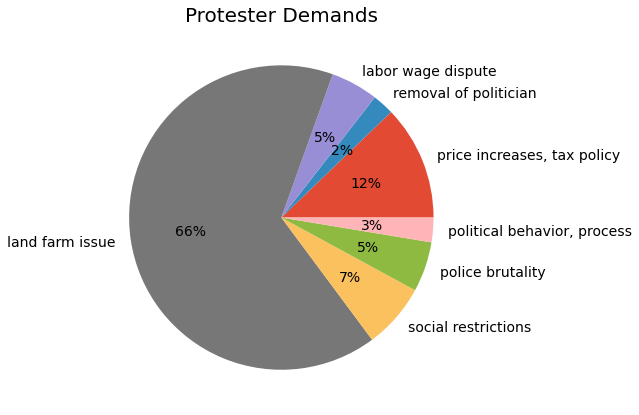

In [20]:
protester_demand_freq = social_movements_train.groupby("protester_demand").size()
protester_demand_names = list(set(social_movements_train.protester_demand))


plt.pie(protester_demand_freq, labels = protester_demand_names, textprops={'fontsize': 14}, autopct='%1.0f%%')
plt.title("Protester Demands", fontdict = {"fontsize" : 20});

One characteristic that shows variations across the different protester demands is the duration of the mobilization. As the following barplot shows, "labor wage dispute" and "land farm issue" show the first and the highest average mobilization duration. Here, it is interesting to note that the demands with the longest average mobilization duration are economic, in opposition to the political demands, which were the most frequent.

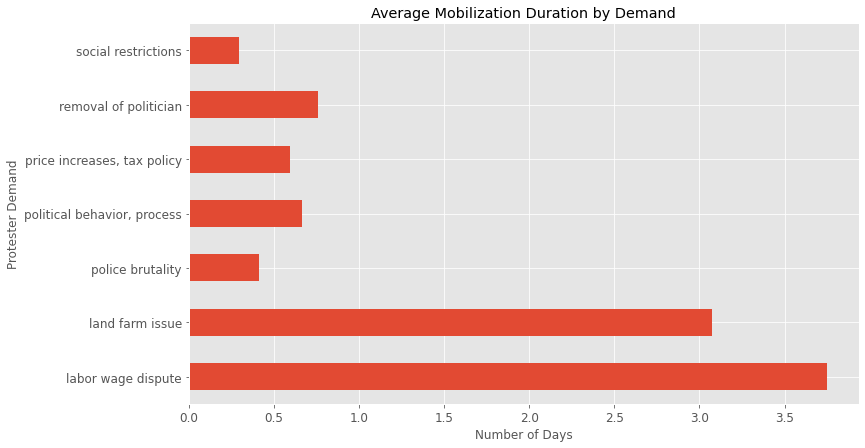

In [21]:
social_movements_train.groupby("protester_demand")["mobilization_duration"].mean().plot.barh();
plt.title("Average Mobilization Duration by Demand")
plt.ylabel("Protester Demand")
plt.xlabel("Number of Days")
plt.xticks(size = 12);
plt.yticks(size = 12);

Another interesting aspect to explore is the relationship between the demands of the protesters and the use of violence. Are certain demands more likely to be accompanied by protesters' violent acts? 

The following barplot shows the proportion of violent mass mobilizations for each demand. It is interesting to observe that, despite it representing only 3% of the demands, "police brutality" mobilizations are show the highest proportion of protester violence. In addition to that, the barplot also indicates that economic demands show the second and the third highest proportions of protester violence ("land farm issue" and "price increases, tax policy", respectively).

Finally, it is also to keep in mind that the proportions of protester violence are not high, overall. Although we can find cases of protester violence in every demand type, none of them represent more than 35% of the mobilizations.

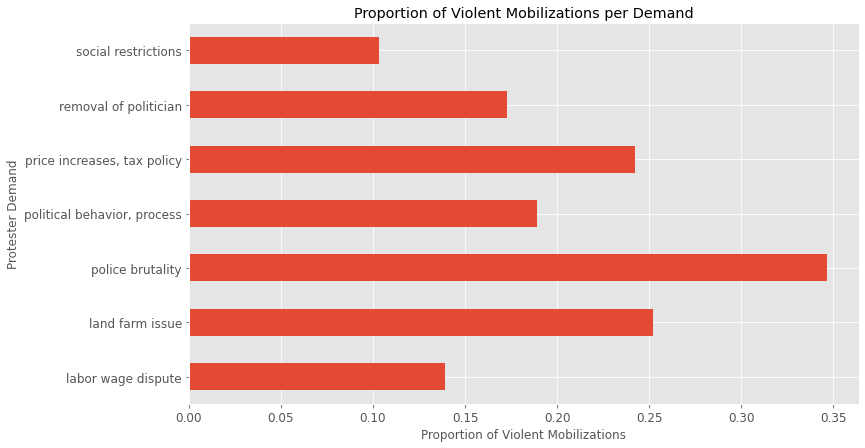

In [22]:
social_movements_train.groupby("protester_demand")["protester_violence"].mean().plot.barh();
plt.title("Proportion of Violent Mobilizations per Demand")
plt.ylabel("Protester Demand")
plt.xlabel("Proportion of Violent Mobilizations")
plt.xticks(size = 12);
plt.yticks(size = 12);

An additional interesting question is whether it is possible to identify a trend in protesters' use of violence in mass mobilizations. In order to explore that, the following figure shows the proportion of violent mass mobilizations for each year from 1990 to 2014. I was not able to identify any significant trend based on the plot, as the increases and decreases in violent mobilizations is not consistent. Most likely, some historical research would be needed to understand the patterns indicated by the figure. 

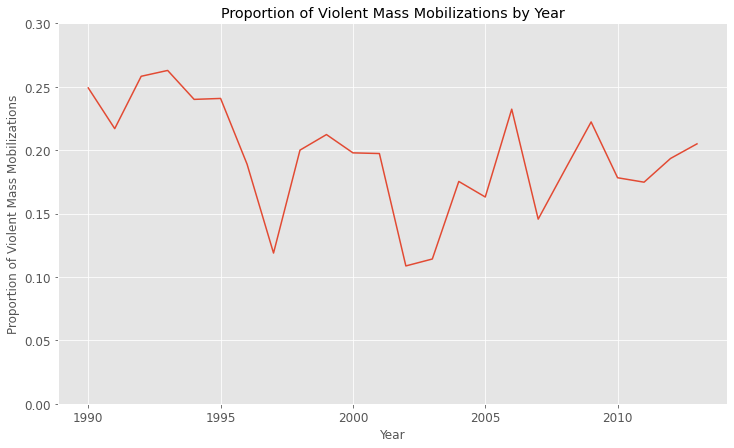

In [23]:
protester_violence_year_prop = social_movements_train.groupby("year")["protester_violence"].mean()
plt.plot(protester_violence_year_prop.index, protester_violence_year_prop);
plt.title("Proportion of Violent Mass Mobilizations by Year")
plt.ylim(0, 0.30);
plt.ylabel("Proportion of Violent Mass Mobilizations")
plt.xlabel("Year")
plt.xticks(size = 12);
plt.yticks(size = 12);

#### 3.1.2 State Response

After going through the data related to the mass mobilizations, I continued with the data about the way in which states respond to mass mobilizations. In this case, there is only one variable that provides relevant information: `state response`. Therefore, the figures in this section are dedicated mostly to explore the relationship between protesters' demands and behavior, and state response. 

First, it is interesting to have an idea of which are the most common state responses in the face of mass mobilization. According to the following figure, the most common ones are forceful state responses, albeit a moderate use of force: "crowd dispersal" represents 64% of state responses, "arrests" represent 19%. Surprisingly, the responses that do not involve force come only as the fourth and sixth more common options: "ignore" represents 6%, while "accomodation" represents only 1%. Violent respones such as "beatings" and "killings" come before them, with 7% and 2%, respectively. 

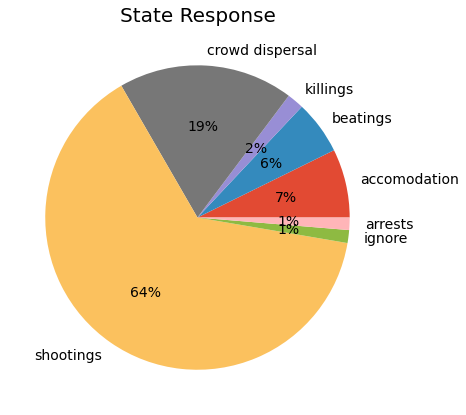

In [24]:
state_response_freq = social_movements_train.groupby("state_response").size()
state_response_names = list(set(social_movements_train.state_response))


plt.pie(state_response_freq, labels = state_response_names, textprops={'fontsize': 14}, autopct='%1.0f%%')
plt.title("State Response", fontdict = {"fontsize" : 20});

Just like in the case of protester demands, state response might show interesting variations regarding the duration of mass mobilization. The following bar plot indicates that there is a significant difference in those cases in which the government opts for "accomodation" (i.e., dialogue with the protesters), response for which the average duration is sliglty more than 6 days. In the case of all the others, there is not much variation besides "killing", which corresponds to an average mobilization duration of slightly more than 1 day.

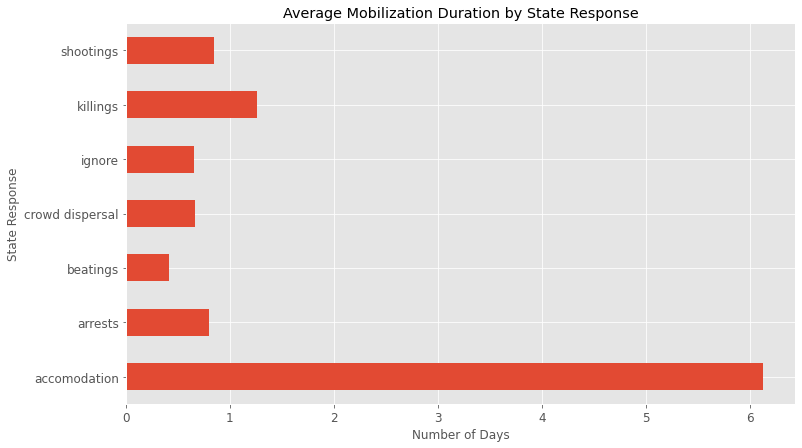

In [25]:
social_movements_train.groupby("state_response")["mobilization_duration"].mean().plot.barh();
plt.title("Average Mobilization Duration by State Response")
plt.ylabel("State Response")
plt.xlabel("Number of Days")
plt.xticks(size = 12);
plt.yticks(size = 12);

In addition to the mobilization duration, it is also interesting to see if there are any particular demands that are more likely to face the use of force by the state as a response. The following figure shows the proportion of forceful responses (i.e., "crowd dispersal", "arrests", "beatings", "shootings", or "killings") for each protester demand. Similar to the case of protester violence, the plot indicates that mobilizations motivated by police brutality concern have the highest proportion of forceful state responses. This might be suggesting an underlying relationship between protester violence and forceful state response, which I explore in the next cells. 

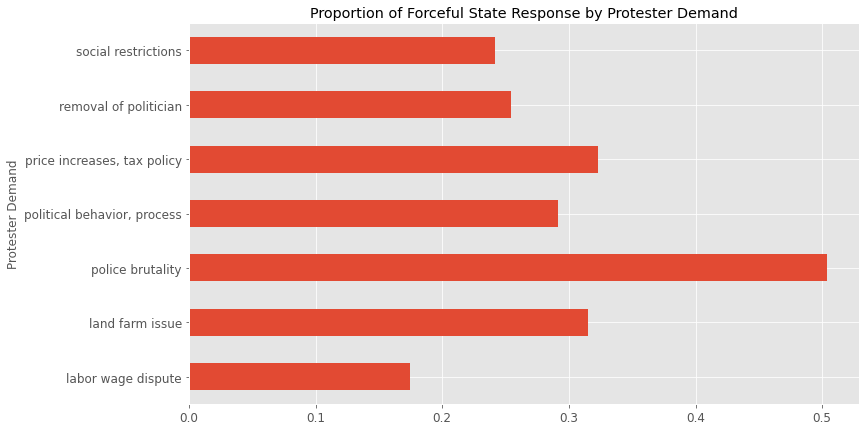

In [26]:
social_movements_train.groupby("protester_demand")["response_use_force"].mean().plot.barh();
plt.title("Proportion of Forceful State Response by Protester Demand")
plt.ylabel("Protester Demand")
plt.xticks(size = 12);
plt.yticks(size = 12);

Another relevant relationship to explore is between the use of violence by protesters and the state response. The following figure shows that there is a higher proportion of protester violence for those state responses that make use of force. The responses that do not make use of force, "ignore" and "accomodation", present low proportions of protester violence: the former shows slightly more than 0.1 and the latter shows even less than 0.1. In contrast to this, state responses that use force present a high proportion of protester violence. All of them but "arrests" have a proportion of violent mass mobilization higher than 0.5. Moreover, for "shooting" and "killing", which are the most extreme of the responses, the proportion is higher than 0.6. This is an important finding, given that it suggests that states are more likely to opt for forceful responses when protesters engage in violent acts. The latter is taken into account while elaborating the machine learning model. 

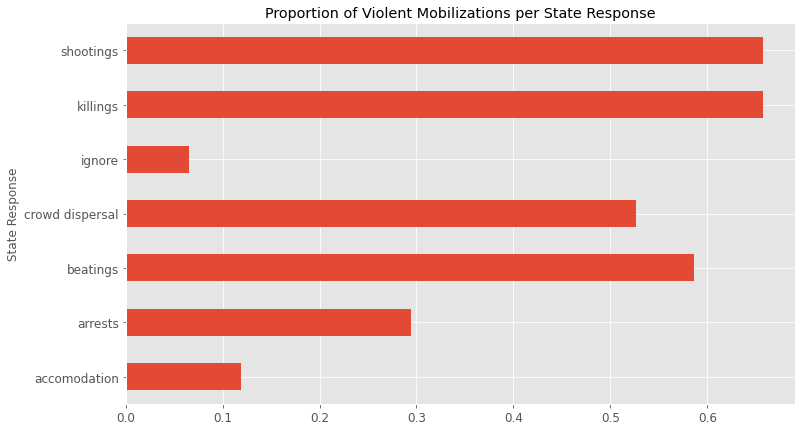

In [27]:
social_movements_train.groupby("state_response")["protester_violence"].mean().plot.barh();
plt.title("Proportion of Violent Mobilizations per State Response")
plt.ylabel("State Response")
plt.xticks(size = 12);
plt.yticks(size = 12);

### 3.2 Regional Data

After analyzing general trends in the data, I decided to look into the regional differences. Informed by the previous section, the exploration of regional data focused on the variables for protesters' demands and behavior, and state response. 

First, the following figure presents an overview of the amount of mass mobilizations in each region per year. As we can see, the numbers vary greately. Although each region presents a different trend that is most likely explained by local events, there are some patterns that can be mentioned. For example, North America, Central America, and Oceania are the regions with consistently low numbers of mass mobilization throughout the years. The MENA region showed a similar pattern, until the mass mobilizations increased by the late 2000s. The spike after 2010 can probably be explained by the Arab Spring. Finally, it is also possible to say that Europe and Asia are usually the regions with the higher amount of mass mobilizations, although it seems that Africa has been coming close in the past decade. 

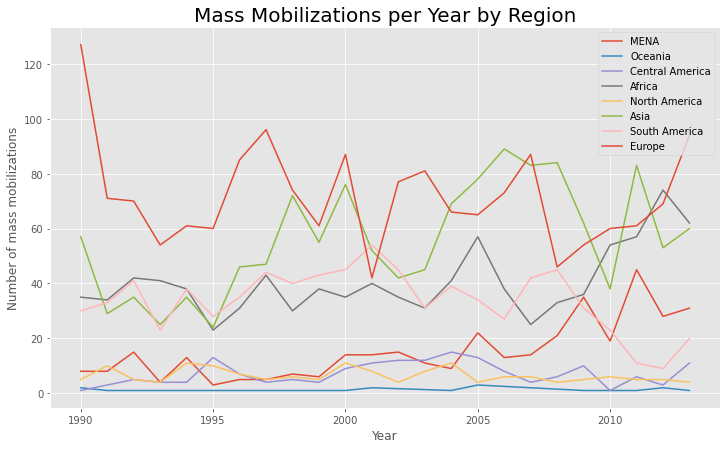

In [28]:
region_names = list(set(social_movements_train.region))

for name in region_names: 
    massmob_per_year = social_movements_train[social_movements_train["region"] == name].groupby("year").size()
    plt.plot(massmob_per_year.index, massmob_per_year, label = name)

plt.legend();
plt.title("Mass Mobilizations per Year by Region", fontdict = {"fontsize" : 20});
plt.ylabel("Number of mass mobilizations");
plt.xlabel("Year");


The general data exploration suggested that protester violence could be an indicator of forceful state response. Because of this, I thought it would be interesting to see if there are differences among regions. As the previous figure shows, the amount of mass mobilizations across regions is varied. Therefore, in order to assess if there are regions in which protester violence is more common than in others, the following figure plots the proportion of protester violence by region. 

The region with the highest proportion of protester violence is Africa, followed by North America, and the MENA region. I think this is interesting because neither of them were among the regions with the highest numbers of mass mobilizations. The situation is similar with Central America, which comes as the fourth region with the highest number of protester violence. Europe, in the other hand, has the second lowest proportion of protester violence, despite it being one of the regions with the highest numbers of mass mobilizations. 

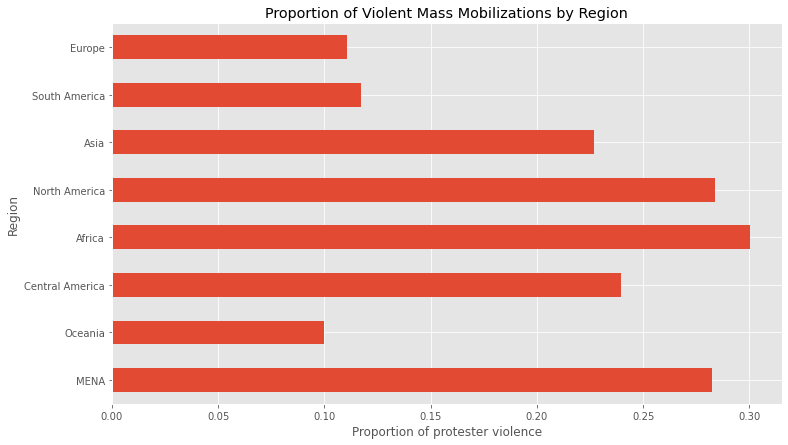

In [29]:
def protester_violence_proportion(region):
    size_protester_violence = social_movements_train[social_movements_train["region"] == region].groupby("protester_violence").size()
    protester_violence_proportion = size_protester_violence/len(social_movements_train[social_movements_train["region"] == region])
    return protester_violence_proportion[1]
    
protester_violence_region_dict = {name:protester_violence_proportion(name) for name in region_names}
protester_violence_region = pd.Series(protester_violence_region_dict)

protester_violence_region.plot.barh()
plt.title("Proportion of Violent Mass Mobilizations by Region")
plt.ylabel("Region")
plt.xlabel("Proportion of protester violence");


The last figure of this section explores the proportion of forceful state response by region. Here, again, the regions showing the highest proportion of forceful state response are not necessarily the same ones that show a high amount of mass mobilization. Nevertheless, similarly to the previous figure, the MENA region, Africa, and Asia have a high proportion of mass mobilization. Europe, on the other hand, is still the region that presents the lowest proportion of violent behavior, this time, from the side of the state. Finally, in relation to the previous plot, it is interesting to note that the regions do not follow the same order regarding the proportion of protester violence and the proportion of forceful state response. This suggest that, even if protester violence might be an important predictor of forceful state response, it is not the only determinant. 

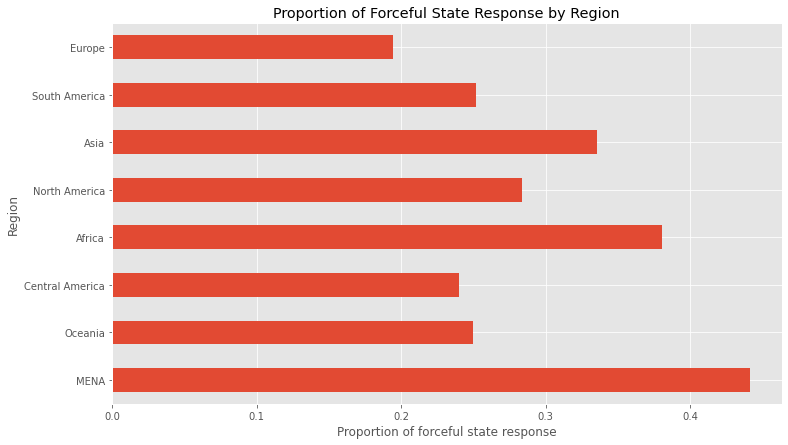

In [30]:
def use_force_proportion(region):
    size_use_force = social_movements_train[social_movements_train["region"] == region].groupby("response_use_force").size()
    use_force_proportion = size_use_force/len(social_movements_train[social_movements_train["region"] == region])
    return use_force_proportion[1]
    
use_force_region_dict = {name:use_force_proportion(name) for name in region_names}
use_force_region = pd.Series(use_force_region_dict)

use_force_region.plot.barh();
protester_violence_region.plot.barh()
plt.title("Proportion of Forceful State Response by Region")
plt.ylabel("Region")
plt.xlabel("Proportion of forceful state response");


## 4. Machine Learning

After exploring the trends in the data, the second part of the project elaborates a machine learning model to predict forceful state response. Given that this is a binary classification problem, I will use logistic regression. Intilially, my hypothesis was that movement duration and protester demands might be predictors of forceful state response. Nevertheless, in the initial data exploration, protester violence emerged as an additional potential predictor. Moreover, the analysis by region showed that there are significant differences between them regarding both protester behavior and state response. Therefore, this model uses four predictors: movement duration, protester demands (coded), protester violence, and region. 

Before working on the machine learning model, I need to make some futher modifications in the data so that it is suitable for logistic regression. In the data cleaning section, I recoded the variable for protester demands and the variable for state response as binary variables. Nevertheless, the inclusion of the variable "region" as a predictor was motivated by the data exploration. Now, "region" is a categorical variable. Therefore, in order to use it as a predictor I have to encode it.

Because logistic regression requires binary variables and given that "region" has several categories, I will use the `MultiLabelBinarizer`function of `sklearn`. This makes the encoding easier and quicker than doing it manually. As a result, I will have 8 new colums (one for each region). In each of them, each observation will be coded 1 when the mobilization took part in that region, and 0 otherwise. These new encoded variables will be later merged with the train and the test data in order to make them usable in the logistic regression model. 

In [31]:
mlb = MultiLabelBinarizer()

regions_encoded = mlb.fit_transform(social_movements_train["region"].str.split('-, '))
#Before merging the newly encoded variables, it is necessary to convert the resulting sparse matrix to a dataframe.
regions_train_df = pd.DataFrame(regions_encoded, columns=mlb.classes_, index=social_movements_train.index)

regions_encoded_test = mlb.fit_transform(social_movements_test["region"].str.split('-, '))
#Before merging the newly encoded variables, it is necessary to convert the resulting sparse matrix to a dataframe.
regions_test_df = pd.DataFrame(regions_encoded_test, columns=mlb.classes_, index=social_movements_test.index)

In [32]:
#This code merges the newly enconded variables with the train data
X_train = social_movements_train[["mobilization_duration", "protester_violence", "economic_demand"]]
X_train = pd.concat([X_train, regions_train_df], axis=1)
y_train = social_movements_train["response_use_force"]

#This code merges the newly enconded variables with the train data
X_test = social_movements_test[["mobilization_duration", "protester_violence", "economic_demand"]]
X_test = pd.concat([X_test, regions_test_df], axis=1)
y_test = social_movements_test["response_use_force"]

After merging the newly encoded "region" variables with the train and test data, it is time for the logistic regression model. As mentioned before, I use four predictors: `mobilization_duration`, `economic_demand`, `protester_violence` and `region`. The selection of these variables can be seen in the previous cell, but `region` is not in the mask because it is added by merging with the `pd.concat` function. 

Now, after fitting the model, the coefficients show that the most important predictor is protester violence. This is interesting because this was not part of the predictors that I had initially planned to include. Nevertheless, the data exploration suggested its relevance. 

Finally, it is possible to assess the model through the accuracy score. It indicates that the model is correct in 81% of its predictions on the test data. However, I also calculate the naive prediction (only predicting `0`), given that the data is unbalanced. The naive accuracy is 73%, 8% less than the accuracy score.

In [33]:
logistic = linear_model.LogisticRegression()

logistic.fit(X_train, y_train)
logistic.coef_

array([[-0.00744717,  2.52111631, -0.37370401,  0.2959895 ,  0.26831864,
        -0.35711339, -0.25805604,  0.64558818, -0.84005682,  0.10983239,
         0.13754401]])

In [34]:
naive_predictions = np.zeros(len(y_test))
naive_accuracy = 1-(y_test.sum()/len(y_test))
accuracy = logistic.score(X_test, y_test)

print(f"Naive accuracy: {naive_accuracy}")
print(f"Logistic regression accuracy: {accuracy}")
print(f"Difference: {accuracy-naive_accuracy}")

Naive accuracy: 0.7273218142548596
Logistic regression accuracy: 0.8104751619870411
Difference: 0.08315334773218142


However, accuracy is not the best way to measure the performance of a classifier. Therefore, for a better alternative, I will calculate the F-score. Although the accuracy score suggested that the naive model was performing decently, the F1 scores reveal that misclassifying all the `1`s leads to poor performance.

In [35]:
predictions = logistic.predict(X_test)
f1_score = metrics.f1_score(predictions, y_test)
f1_score_naive = metrics.f1_score(naive_predictions, y_test)

print(f"F1 score: {f1_score}")
print(f"F1 score naive: {f1_score_naive}")

F1 score: 0.5951557093425606
F1 score naive: 0.0


This confusion matrix gives a visual idea of the accuracy of the model.

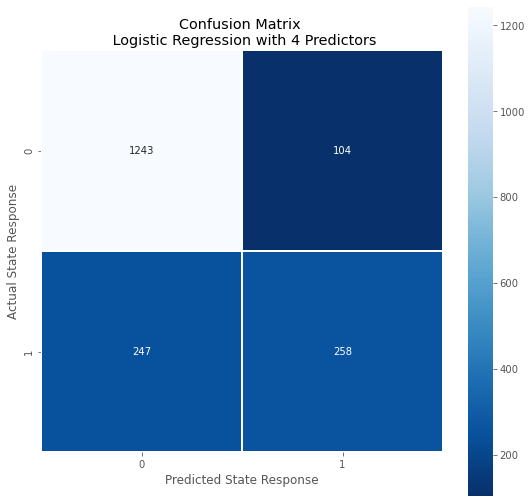

In [36]:
conf_matr = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize = (9,9))
sns.heatmap(conf_matr, annot = True, fmt = "d", linewidth = .5, square = True, cmap = "Blues_r")
plt.xlabel("Predicted State Response")
plt.ylabel("Actual State Response");
plt.title("Confusion Matrix \n Logistic Regression with 4 Predictors");

## 5. Conclusions

In this project, I have worked with the "Mass Mobilizations Data" dataset with two objectives. The first one was to explore the data in look for interesting patters in mass mobilizations across regions. In particular, I was interested in protesters' demands and behavior, and the way in which states respond to them. The second was to elaborate a machine learning model that allowed me to predict forceful response from the states in the face of mass mobilizations. 

After the data cleaning process, the third section of the notebook was dedicated to the exploration of the data. Although it was difficult to find patterns regarding the number of mass mobilizations per region, this initial exploration was useful to identify relevant variables for the machine learning model. This was the case for protester violence, as the figures in the data exploration suggested some relation to the use of force by states, both when analyzing the data in general and when making the analysis by region.

The fourth and last section was dedicated to the machine learning model. My intention was to predict whether the state opts for a forceful resposne or it does not in the face of mass mobilization. Therefore, given that it is a binary classification problem, I chose logistic regression for the model. As discussed before, using four predictors in the model (protester demands, mobilization duration, protester violence, and region) achieved an accuracy score of 81%. Nevertheless, it is important to keep in mind that the "Mass Mobilization Data" dataset is not balanced in the number of forceful state responses. Given that this might optimistically bias the results, it would be interesting to perform the same analysis and test the model after choosing a balanced sample.

## 6. Sources

Clark, David; Regan, Patrick, 2016, "Mass Mobilization Protest Data", https://doi.org/10.7910/DVN/HTTWYL, Harvard Dataverse, V5, UNF:6:F/k8KUqKpCa5UssBbL/gzg== [fileUNF]